# Interpretability Plots

These visualizations are based on the integrated gradients from FART. Visualization are made using the RDKit SimilarityMap functionality which allows for heatmaps to be projected onto molecules. Two functions provide an easy interface to produce interpretability plots: 

* ``` visualize_gradients ``` for output in a jupyter notebook 

* ``` save_high_quality_png ``` to save a local copy of a large png version of the heatmap. 

In [176]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
from transformers import pipeline

model_name = "FartLabs/Model_C"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer_name = "FartLabs/Model_C"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

cls_explainer = SequenceClassificationExplainer(model, tokenizer)

pipe = pipeline("text-classification", model=model_name)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


## Utils

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
from IPython.display import Image
print(rdkit.__version__)

2024.09.2


In [119]:

def get_taste_from_smiles(smiles): 
    # Original output
    output = pipe(smiles)

    # Mapping of labels to tastes
    taste_labels = ['BITTER', 'SOUR', 'SWEET', 'UMAMI', 'UNDEFINED']

    # Extract label and score
    label_info = output[0]
    label_index = int(label_info['label'].split('_')[1])  # Get the numeric part of the label
    score = label_info['score']

    # Reassign label
    new_label = taste_labels[label_index]

    # Format the title string
    title_string = f"{new_label} score: {score:.2f}"

    # Output the title string
    return title_string

def calculate_aspect_ratio(molecule, base_size):
    """
    Calculates the canvas width and height based on the molecule's aspect ratio.

    Parameters:
    - molecule (Mol): RDKit molecule object.
    - base_size (int): The base size of the canvas, typically 400.

    Returns:
    - (int, int): Calculated width and height for the canvas.
    """
    conf = molecule.GetConformer()
    atom_positions = [conf.GetAtomPosition(i) for i in range(molecule.GetNumAtoms())]
    x_coords = [pos.x for pos in atom_positions]
    y_coords = [pos.y for pos in atom_positions]
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)
    aspect_ratio = width / height if height > 0 else 1

    canvas_width = max(base_size, int(base_size * aspect_ratio)) if aspect_ratio > 1 else base_size
    canvas_height = max(base_size, int(base_size / aspect_ratio)) if aspect_ratio < 1 else base_size

    return canvas_width, canvas_height

def visualize_gradients(smiles, bw=True, padding=0.05):
    """
    Visualizes atom-wise gradients or importance scores for a given molecule 
    based on the SMILES representation as a similarity map.

    Parameters:
    - smiles (str): The SMILES string of the molecule to visualize.
    - bw (bool): If True, renders the molecule in black and white (default is False).

    Returns:
    - None: Displays the generated similarity map in the notebook.
    """
    
    print(get_taste_from_smiles(smiles))

    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    Chem.rdDepictor.Compute2DCoords(molecule)
    
    # Set up canvas size based on aspect ratio
    base_size = 400
    width, height = calculate_aspect_ratio(molecule, base_size)
    d = Draw.MolDraw2DCairo(width, height)
    #Draw.SetACS1996Mode(d.drawOptions(),Draw.MeanBondLength(molecule))
    d.drawOptions().padding = padding
    
    # Optionally set black and white palette
    if bw:
        d.drawOptions().useBWAtomPalette()
    
    # Get token importance scores and map to atoms
    token_importance = cls_explainer(smiles)
    atom_importance = [c[1] for c in token_importance if c[0].isalpha()]
    num_atoms = molecule.GetNumAtoms()
    atom_importance = atom_importance[:num_atoms]
    
    # Generate and display a similarity map based on atom importance scores
    SimilarityMaps.GetSimilarityMapFromWeights(molecule, atom_importance, draw2d=d)
    
    # Convert drawing to image and display
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    img = Image(data=png_data)
    return img


In [ ]:
def save_high_quality_png(smiles, title, bw=True, padding=0.05):
    """
    Generates a high-quality PNG of atom-wise gradients or importance scores for a molecule.

    Parameters:
    - smiles (str): The SMILES string of the molecule to visualize.
    - token_importance (list): List of importance scores for each atom.
    - bw (bool): If True, renders the molecule in black and white.
    - padding (float): Padding for molecule drawing.
    - output_file (str): Path to save the high-quality PNG file.

    Returns:
    - None
    """
    
    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    Chem.rdDepictor.Compute2DCoords(molecule)
    
    # Get token importance scores and map to atoms
    token_importance = cls_explainer(smiles)
    atom_importance = [c[1] for c in token_importance if c[0].isalpha()]
    num_atoms = molecule.GetNumAtoms()
    atom_importance = atom_importance[:num_atoms]
    
    # Set a large canvas size for high resolution
    d = Draw.MolDraw2DCairo(1500, 1500)

    dopts = d.drawOptions()
    dopts.padding = padding    
    dopts.maxFontSize = 2000
    dopts.bondLineWidth = 5

    # Optionally set black and white palette
    if bw:
        d.drawOptions().useBWAtomPalette()
    
    # Generate and display a similarity map based on atom importance scores
    SimilarityMaps.GetSimilarityMapFromWeights(molecule, atom_importance, draw2d=d)

    # Draw molecule with color highlights
    d.FinishDrawing()
    
    # Save to PNG file with high quality
    with open(f"{title}.png", "wb") as png_file:
        png_file.write(d.GetDrawingText())
    
    print(f"High-quality PNG file saved as {title}.png")
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    img = Image(data=png_data)
    return img


In [219]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
import pandas as pd
import matplotlib.pyplot as plt

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2)
    else:
        print("not valid mol")
    return fp

fart_df = pd.read_csv('../fart_curated.csv')
fart_df['Fingerprint'] = fart_df['Canonicalized SMILES'].apply(get_fingerprint)

def find_and_plot_top_similar(smiles, top_n=5):
    """
    Finds and plots the top `top_n` most similar molecules to the input SMILES string 
    from the `fart_df` DataFrame, displaying them in a grid with their respective labels.

    Parameters:
    - smiles (str): SMILES string of the target molecule.
    - fart_df (pd.DataFrame): DataFrame containing "Canonicalized SMILES", "Original Labels", and "Fingerprint".
    - top_n (int): Number of most similar molecules to find and plot (default is 5).
    
    Returns:
    - None
    """
    
    # Convert input SMILES to RDKit molecule and compute fingerprint
    target_mol = Chem.MolFromSmiles(smiles)
    target_fp = AllChem.GetMorganFingerprintAsBitVect(target_mol, radius=2)

    # Initialize list to hold top similar molecules
    top_similar = []

    # Iterate through molecules in fart_df and compute similarity using precomputed fingerprints
    for _, row in fart_df.iterrows():
        fp = row["Fingerprint"]
        if fp is not None:
            similarity = DataStructs.TanimotoSimilarity(target_fp, fp)
            
            # Maintain a list of the top `top_n` most similar molecules
            if len(top_similar) < top_n:
                top_similar.append((similarity, row["Canonicalized SMILES"], row["Canonicalized Taste"]))
                top_similar.sort(reverse=True, key=lambda x: x[0])
            elif similarity > top_similar[-1][0]:  # Replace the lowest if similarity is higher
                top_similar[-1] = (similarity, row["Canonicalized SMILES"], row["Canonicalized Taste"])
                top_similar.sort(reverse=True, key=lambda x: x[0])

    # Extract molecules and labels from the sorted top similar list
    top_mols = [Chem.MolFromSmiles(x[1]) for x in top_similar]
    labels = [f"{x[2]} (Similarity: {x[0]:.2f})" for x in top_similar]

    # Plot molecules in a grid with labels
    img = Draw.MolsToGridImage(top_mols, molsPerRow=3, subImgSize=(300, 300), legends=labels)
    display(img)


[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerator
[13:43:30] DEPRECATION WARNING: please use MorganGenerat

## Plots

UNDEFINED score: 0.78


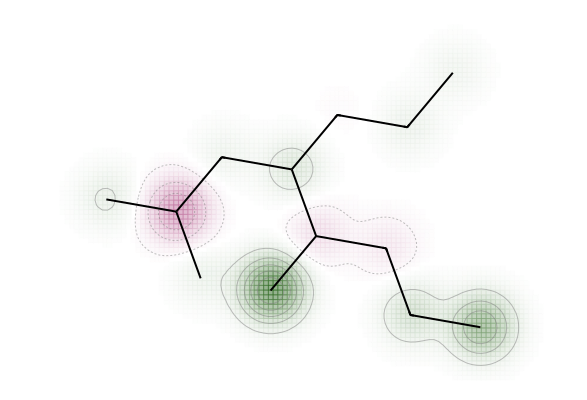

In [231]:
alkane = "CCCC(CC(C)C)C(CCC)C"

visualize_gradients(alkane, bw=True)


High-quality PNG file saved as alkane.png


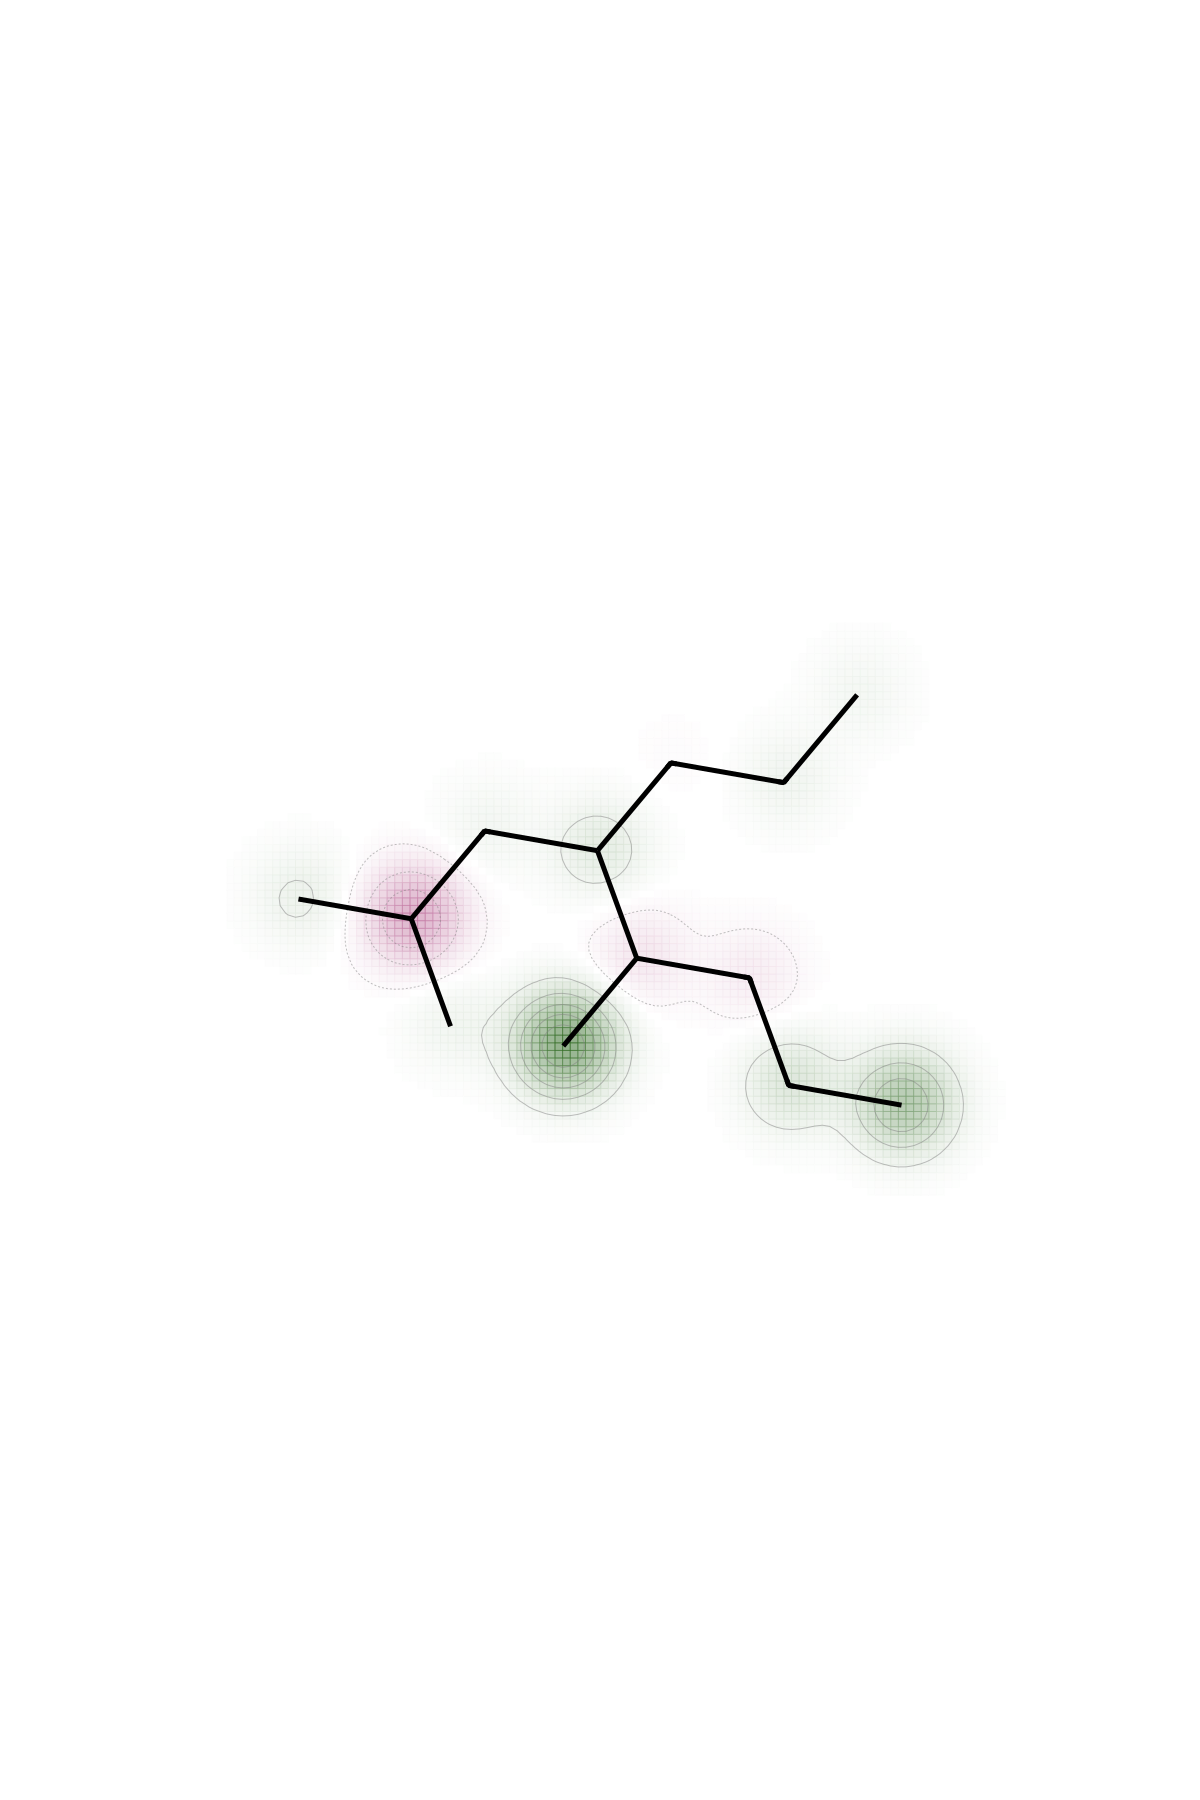

In [317]:
save_high_quality_png(alkane, "alkane", padding=0.1)

SOUR score: 0.66


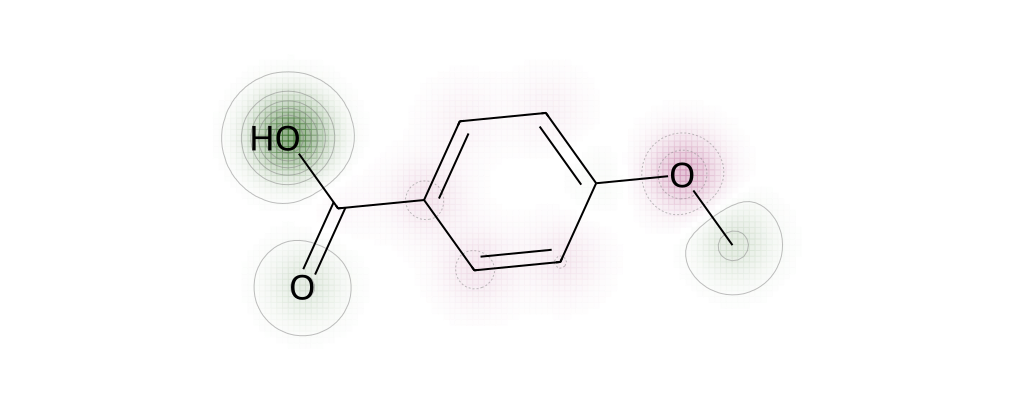

In [213]:
benzoic_acid = "O=C(O)c1ccc(OC)cc1"

visualize_gradients(benzoic_acid, bw=True, padding=0.1)

High-quality PNG file saved as benzoic_acid.png


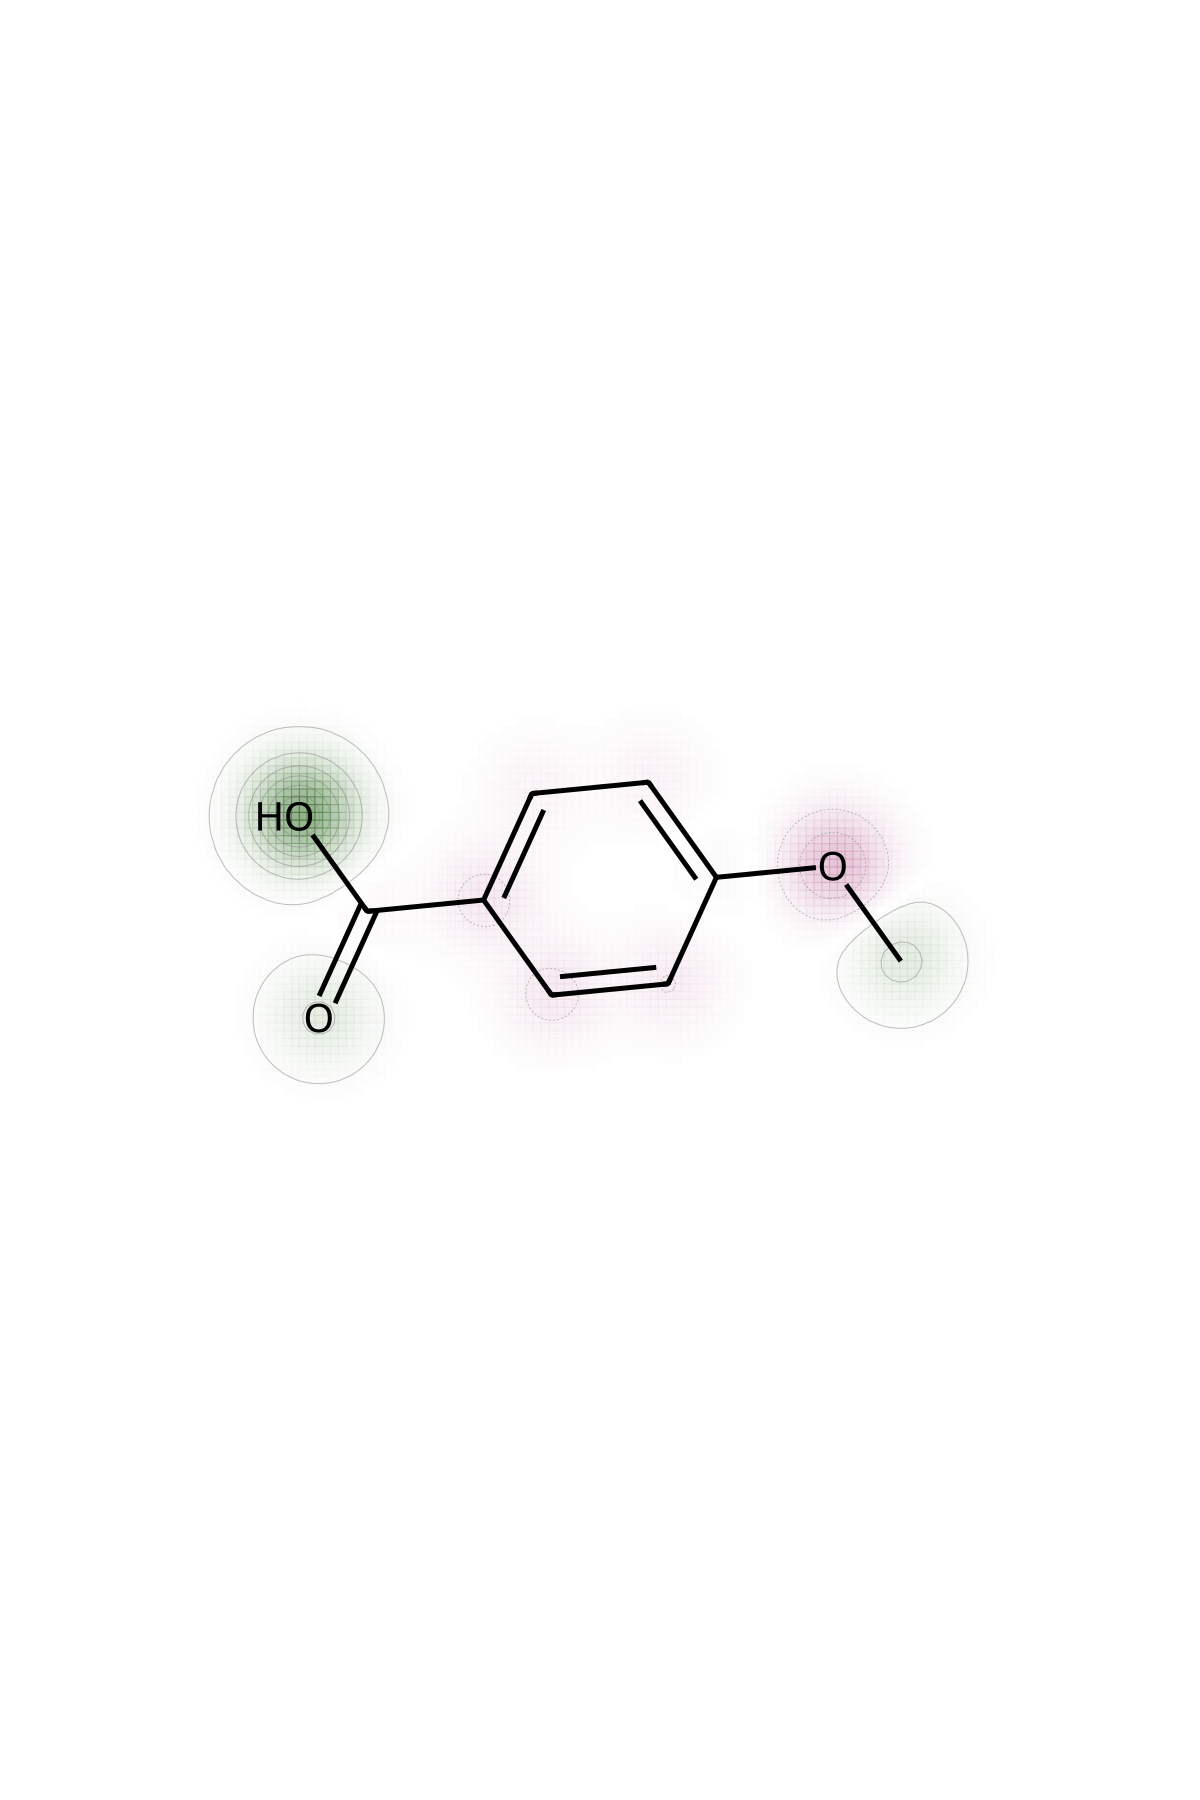

In [312]:
save_high_quality_png(benzoic_acid, "benzoic_acid", padding=0.1)

High-quality PNG file saved as ethyl_benzoate.png
SWEET score: 0.65


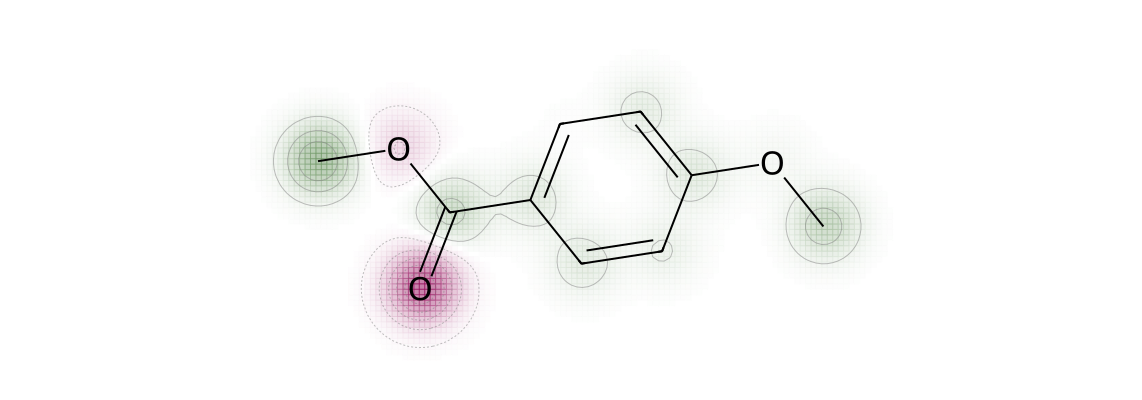

In [ ]:
ethyl_benzoate = "O=C(c1ccc(OC)cc1)OC" # ethyl benzoate indeed does taste sweetish 

visualize_gradients(ethyl_benzoate, bw=True, padding=0.1)

High-quality PNG file saved as ethyl_benzoate.png


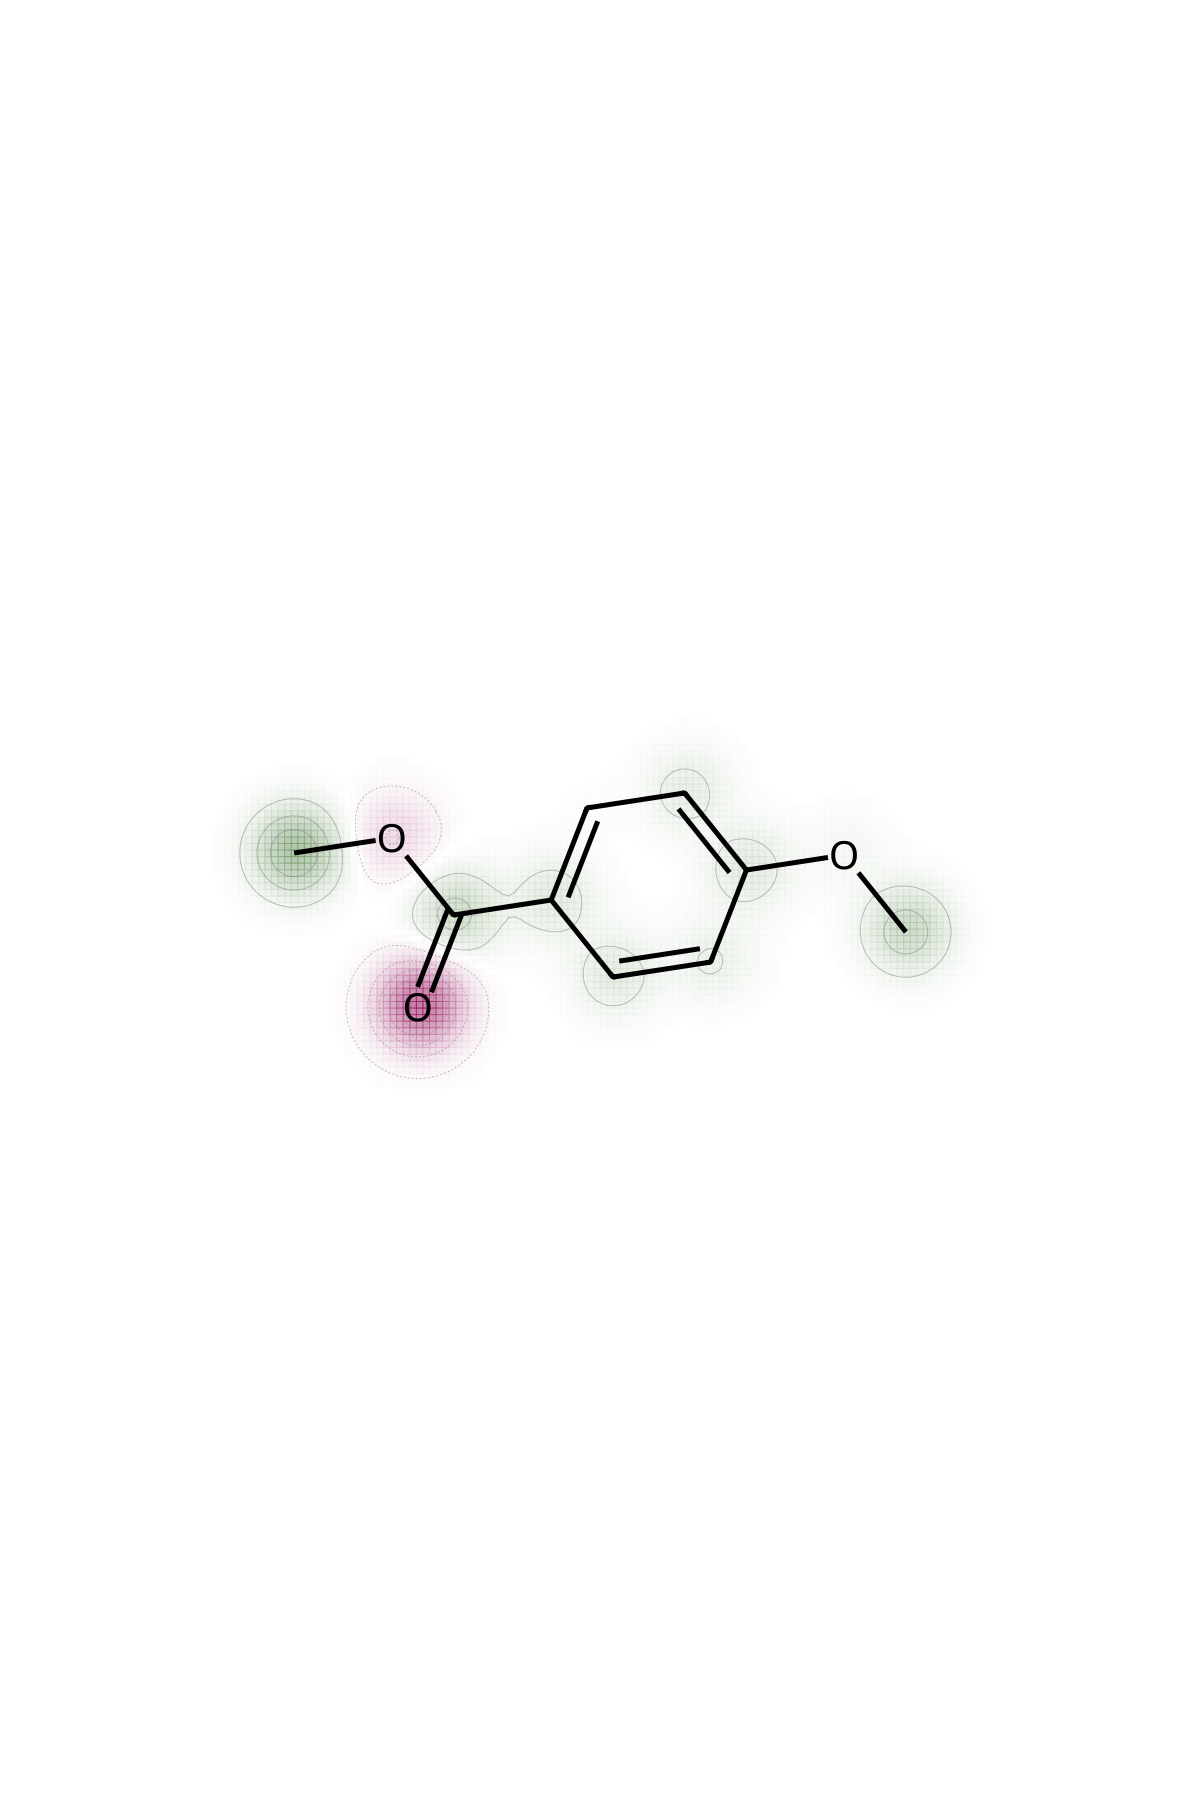

In [311]:
save_high_quality_png(ethyl_benzoate, "ethyl_benzoate", padding=0.1)


High-quality PNG file saved as catechin_bitter.png
BITTER score: 0.85


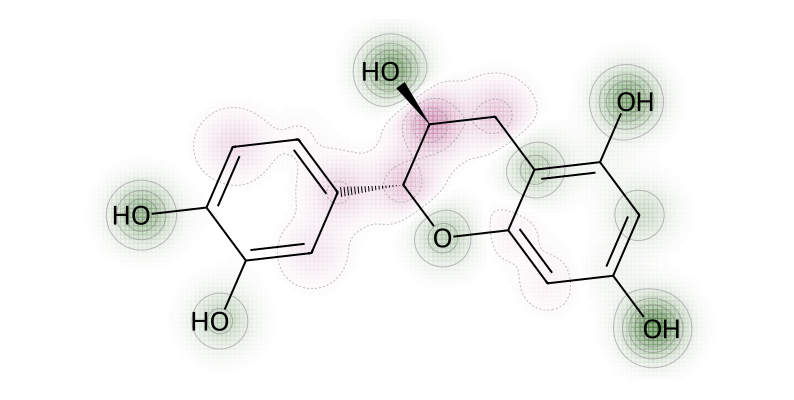

In [ ]:
catechin = "Oc1ccc(cc1O)[C@H]3Oc2cc(O)cc(O)c2C[C@@H]3O" # a very bitter flavenoid, part of the polyphenol group

visualize_gradients(catechin, bw=True)

High-quality PNG file saved as catechin_bitter.png


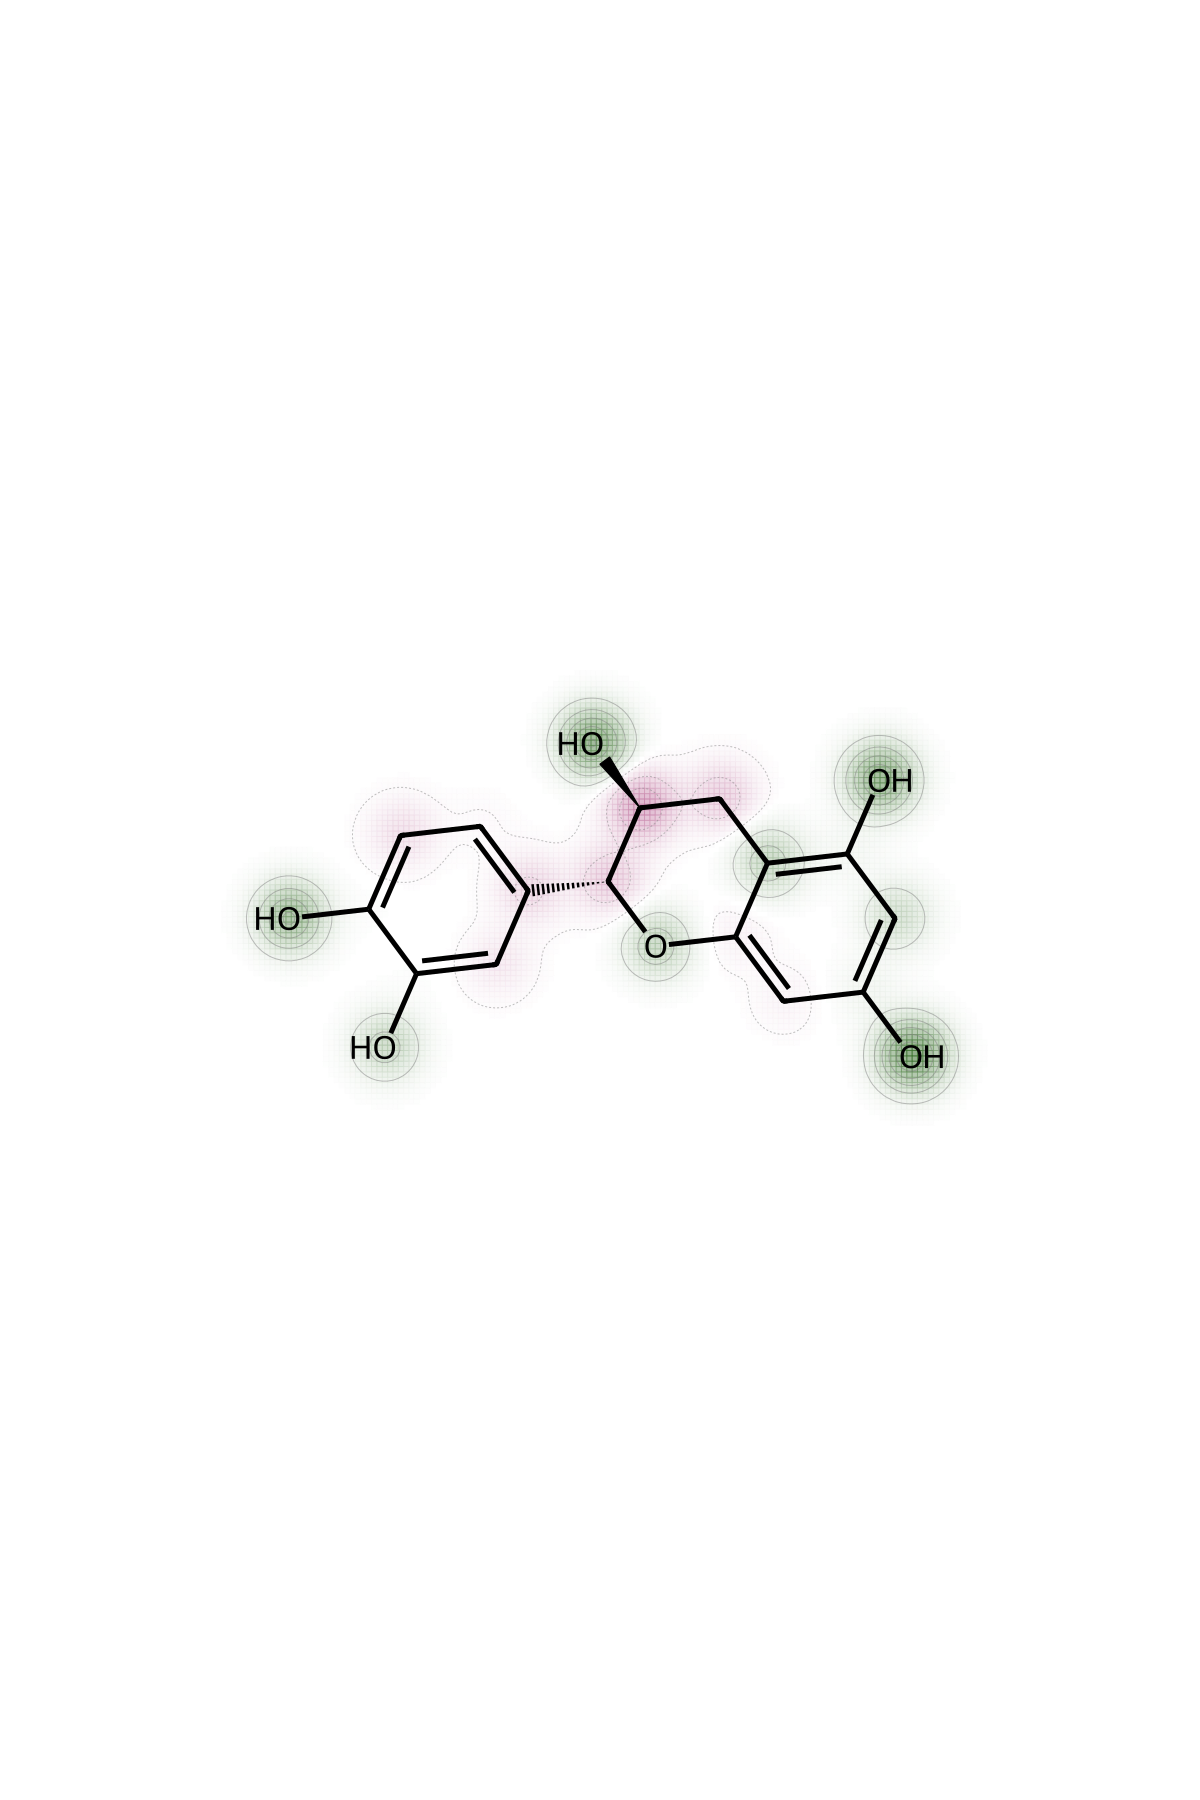

In [313]:
save_high_quality_png(catechin, "catechin_bitter", padding=0.1)


BITTER score: 0.64


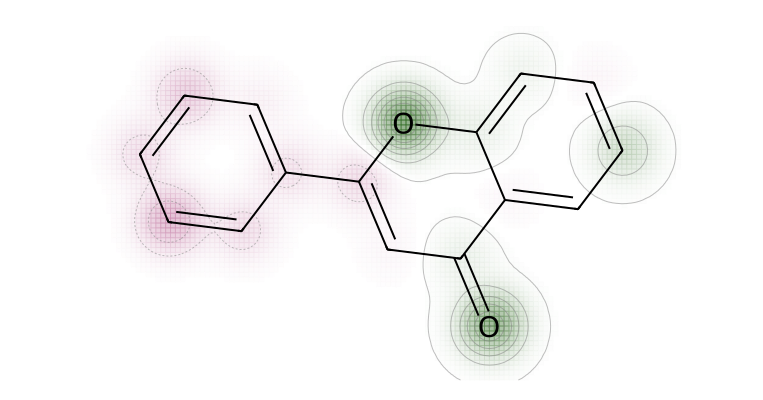

In [ ]:
flavone_backbone = "C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2" # often referred to as a common bitterness scaffold

visualize_gradients(flavone_backbone)

SWEET score: 0.71


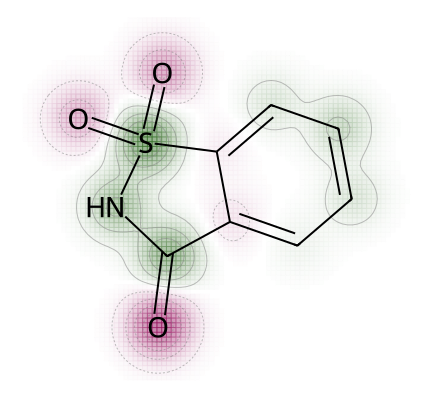

In [194]:
sacharin = "O=C2c1ccccc1S(=O)(=O)N2"
visualize_gradients(sacharin)


High-quality PNG file saved as saccharin.png


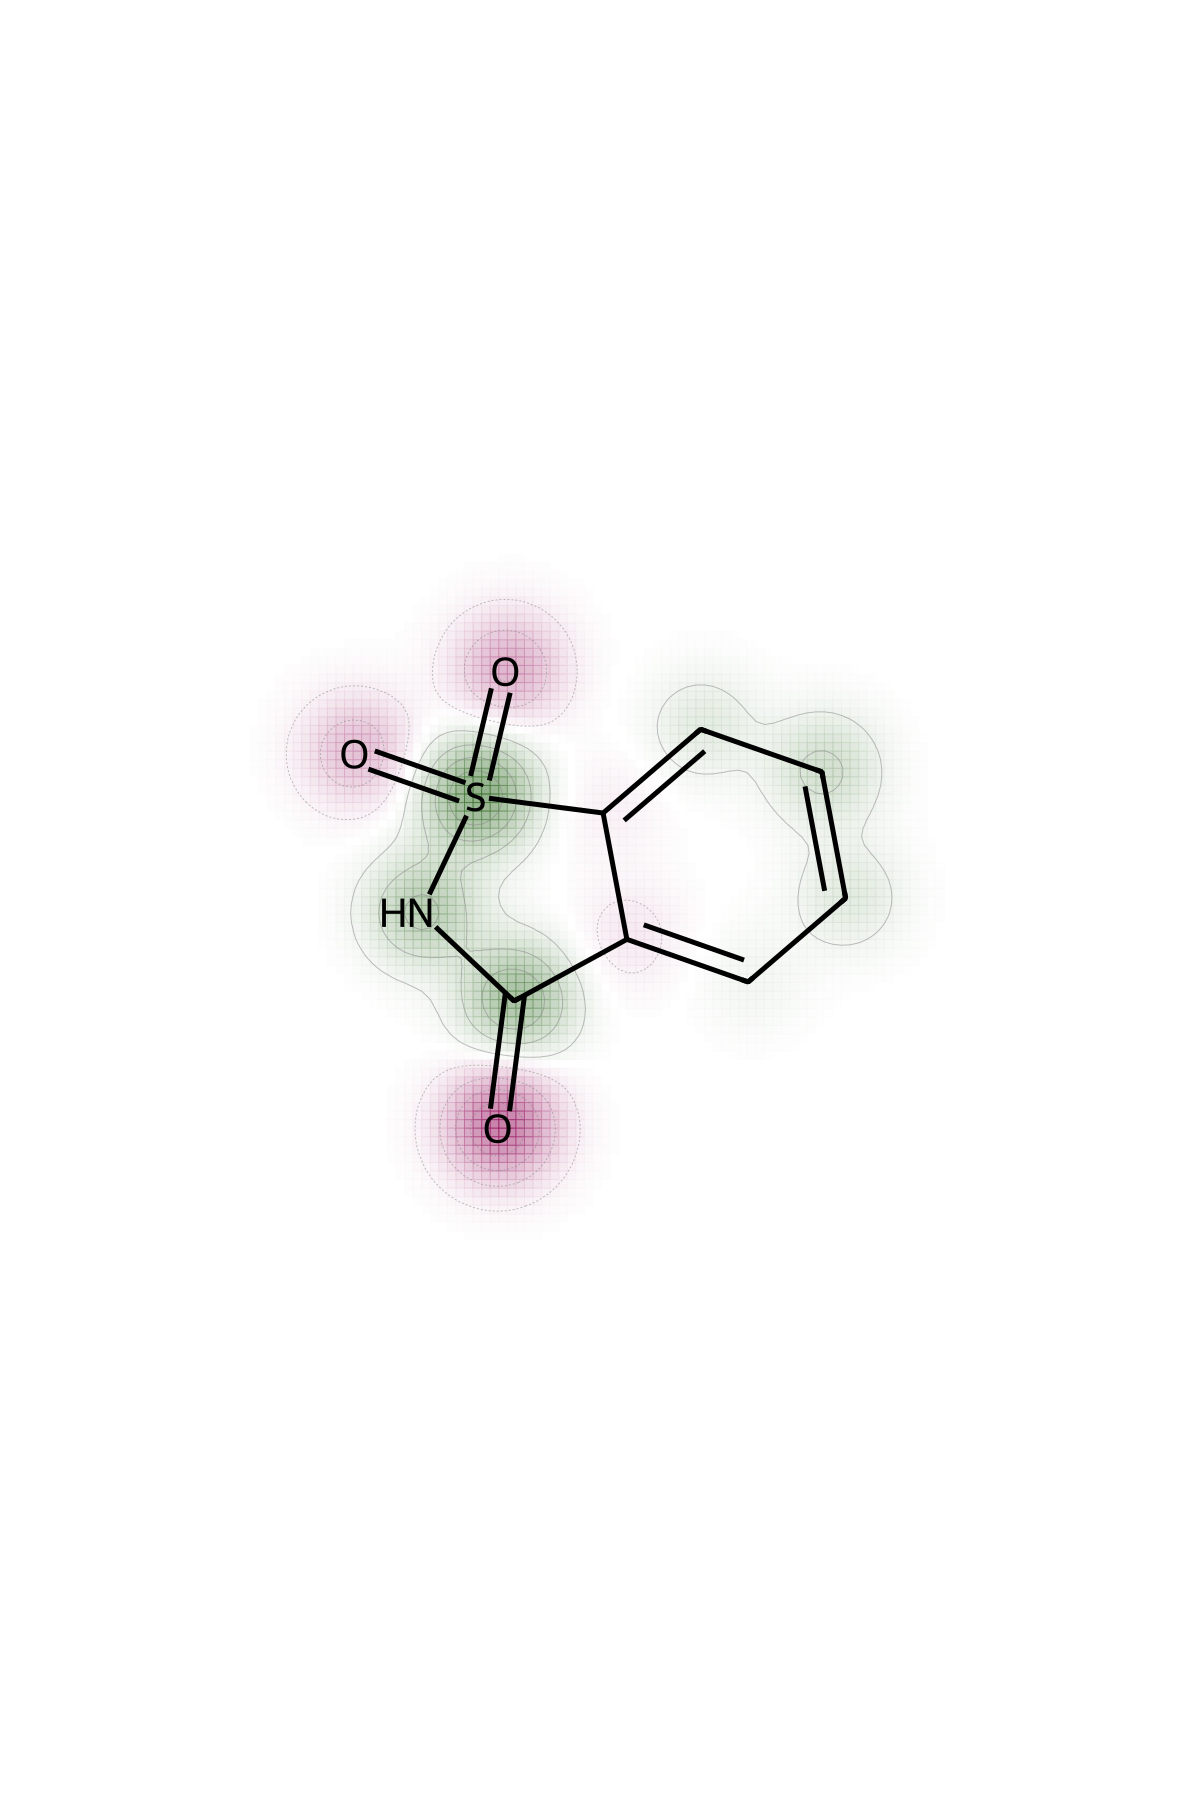

In [316]:
save_high_quality_png(sacharin, "saccharin", padding=0.13)

UMAMI score: 0.45


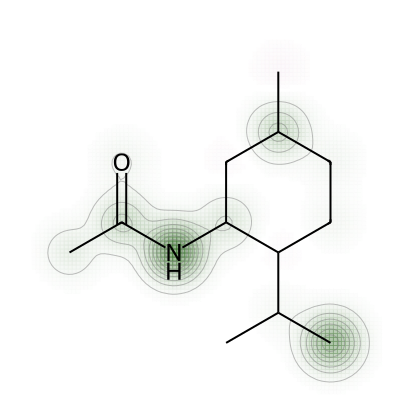

In [333]:
random_analog = "CC(C1C(CC(CC1)C)NC(C)=O)C"
visualize_gradients(random_analog)

BITTER score: 0.76


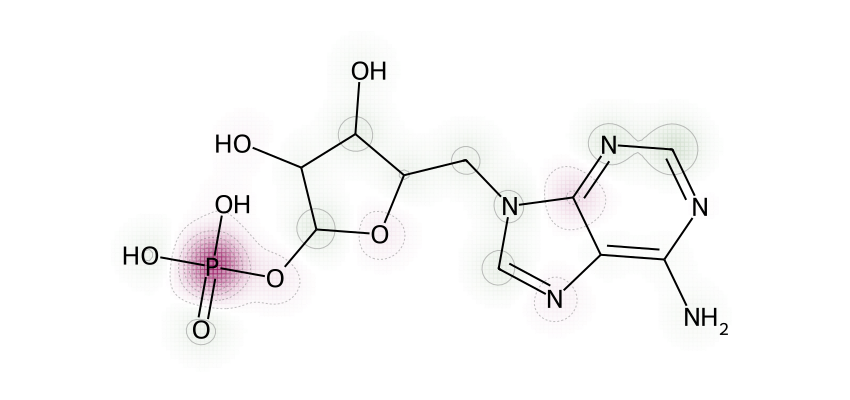

In [337]:
AMP = "NC1=C(C2=NC=N1)N=CN2CC3OC(OP(O)(O)=O)C(O)C3O"
visualize_gradients(AMP)

SOUR score: 0.58


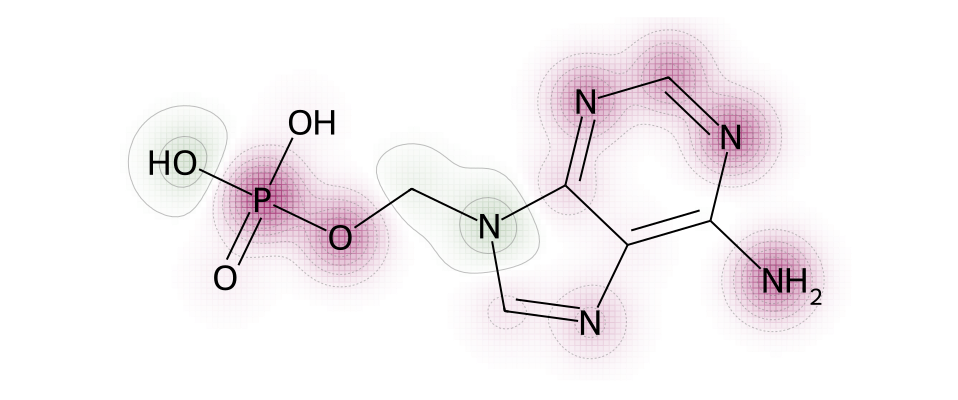

In [ ]:
AMP_short = "NC1=C(N=CN2COP(O)(O)=O)C2=NC=N1"
visualize_gradients(AMP_short)

High-quality PNG file saved as umami_amide.png
UMAMI score: 0.98


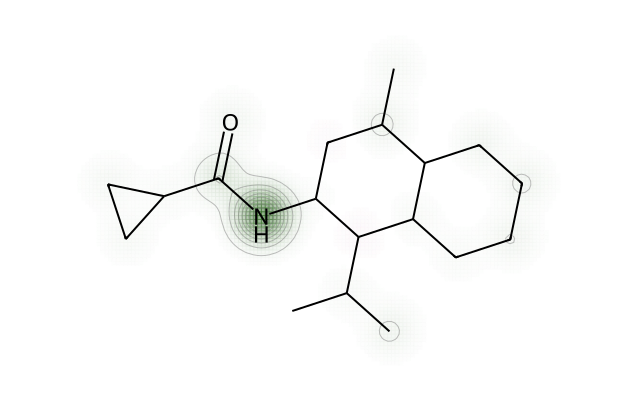

In [ ]:
random_amide = "CC(C)C1C(NC(C2CC2)=O)CC(C)C3C1CCCC3" # acid?
visualize_gradients(random_amide)

High-quality PNG file saved as umami_amide.png


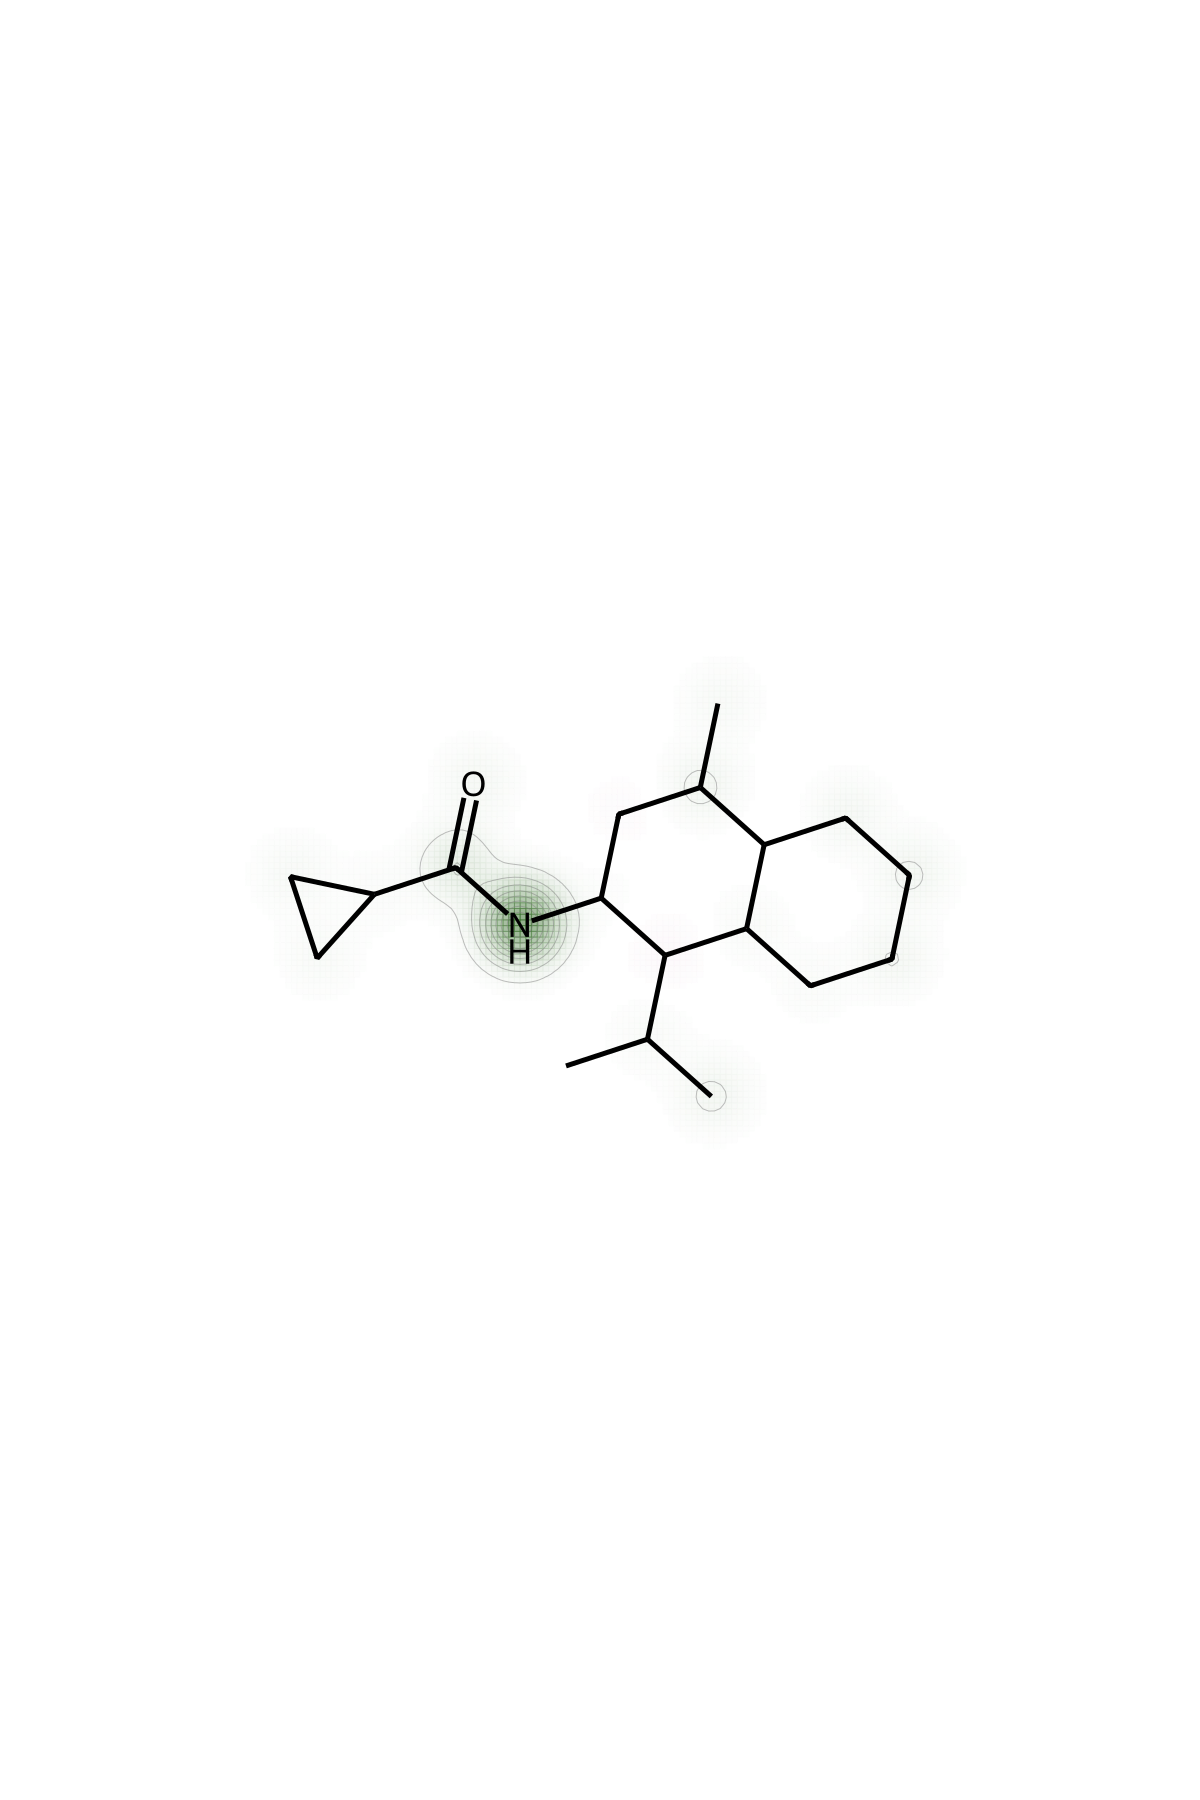

In [315]:
save_high_quality_png(random_amide, "umami_amide", padding=0.1)

[13:36:33] DEPRECATION WARNING: please use MorganGenerator


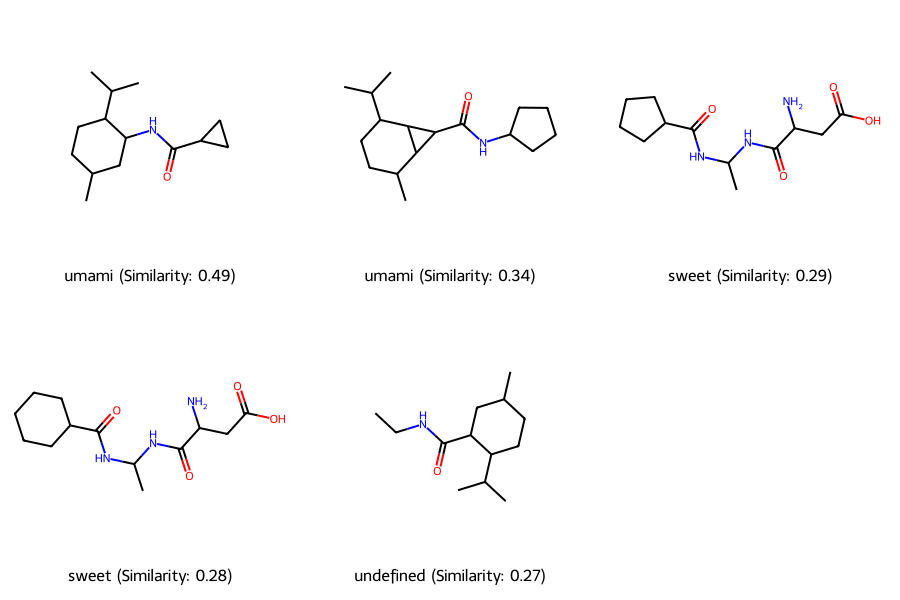

In [206]:
find_and_plot_top_similar(random_amide)

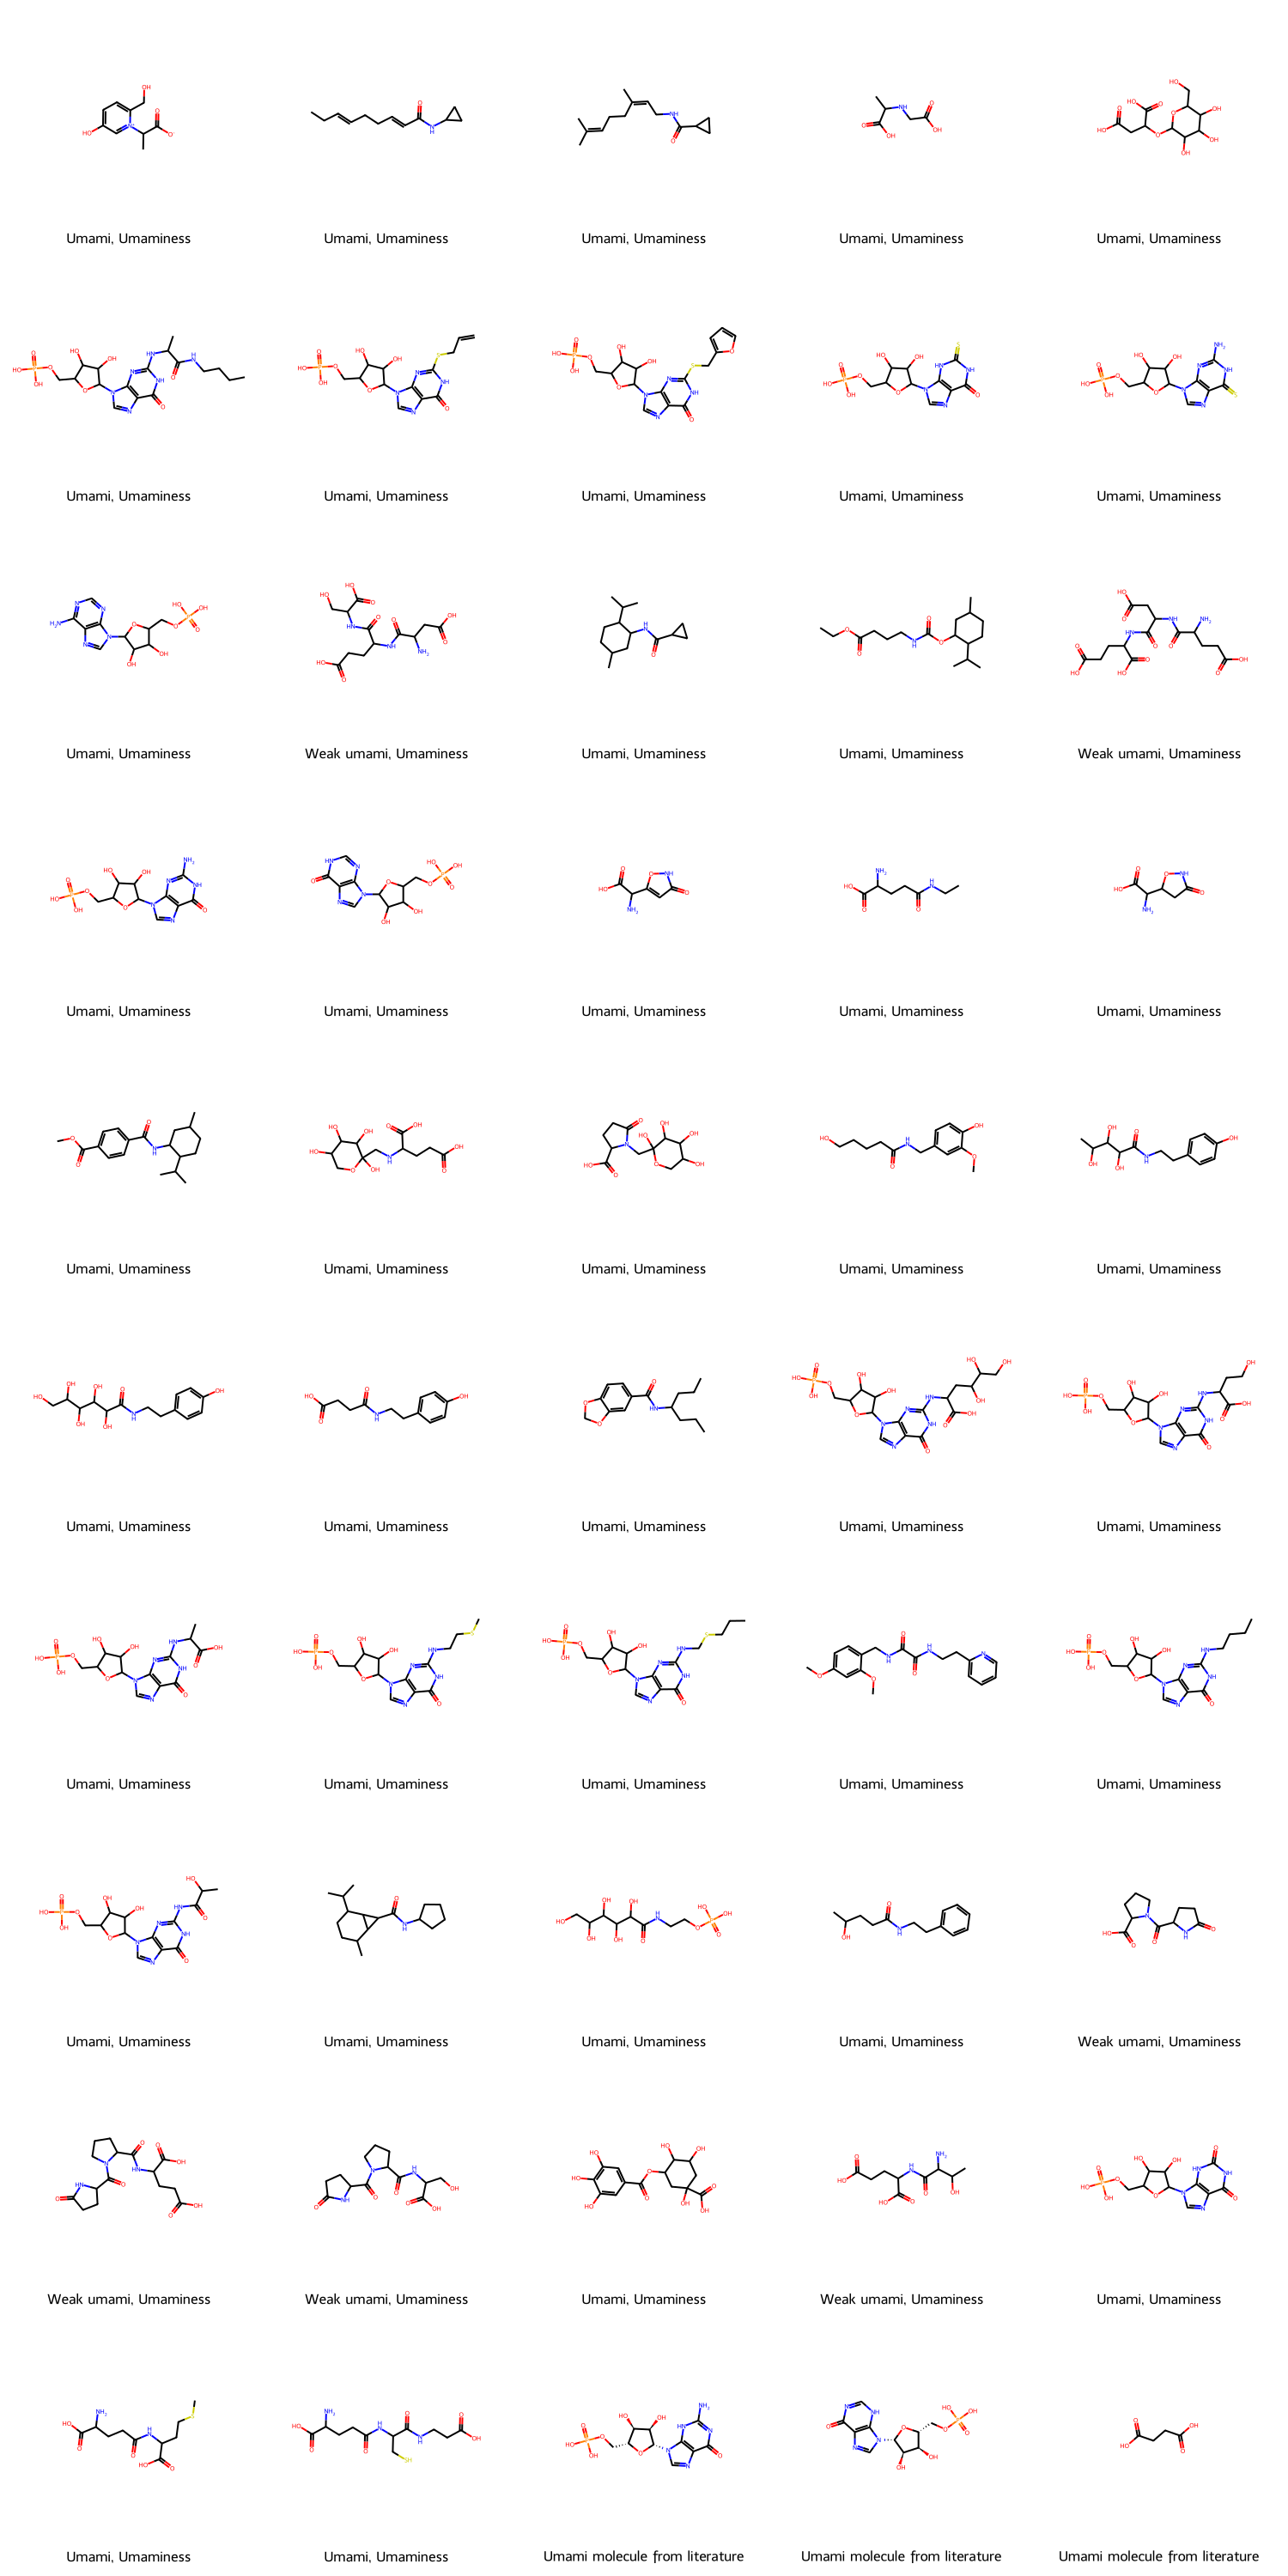

In [200]:
acids = fart_df[(fart_df['Canonicalized Taste'] == "umami")]
acid_mols = [Chem.MolFromSmiles(smi) for smi in acids['Canonicalized SMILES']]
labels = acids['Original Labels'].tolist()  # Get labels for each molecule

# Plot the molecules in a grid with their labels
start_index = 0
end_index = 50

# Slice the molecules and labels lists for the desired range
next_50_mols = acid_mols[start_index:end_index]
next_50_labels = labels[start_index:end_index]

# Plot the next 50 molecules
img = Draw.MolsToGridImage(next_50_mols, molsPerRow=5, subImgSize=(300, 300), legends=next_50_labels)
display(img)

In [ ]:
alkane # no, not in dataset
benzoic_acid # yes
ethyl_benzoate # yes 
catechin  # yes
random_amide # no
saccharin # yes


## Plotting analogues of 4

UNDEFINED score: 0.63


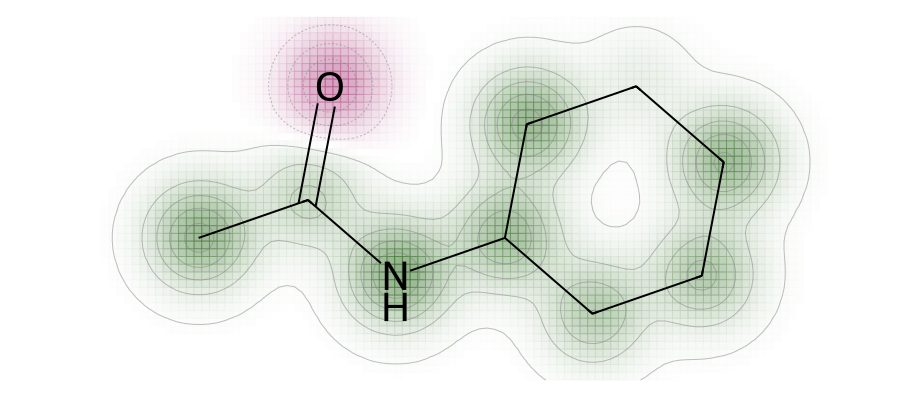

In [348]:
visualize_gradients(a6)

High-quality PNG file saved as original.png
High-quality PNG file saved as analog1.png
High-quality PNG file saved as analog2.png
High-quality PNG file saved as analog3.png
High-quality PNG file saved as analog4.png
High-quality PNG file saved as analog5.png
High-quality PNG file saved as analog6.png


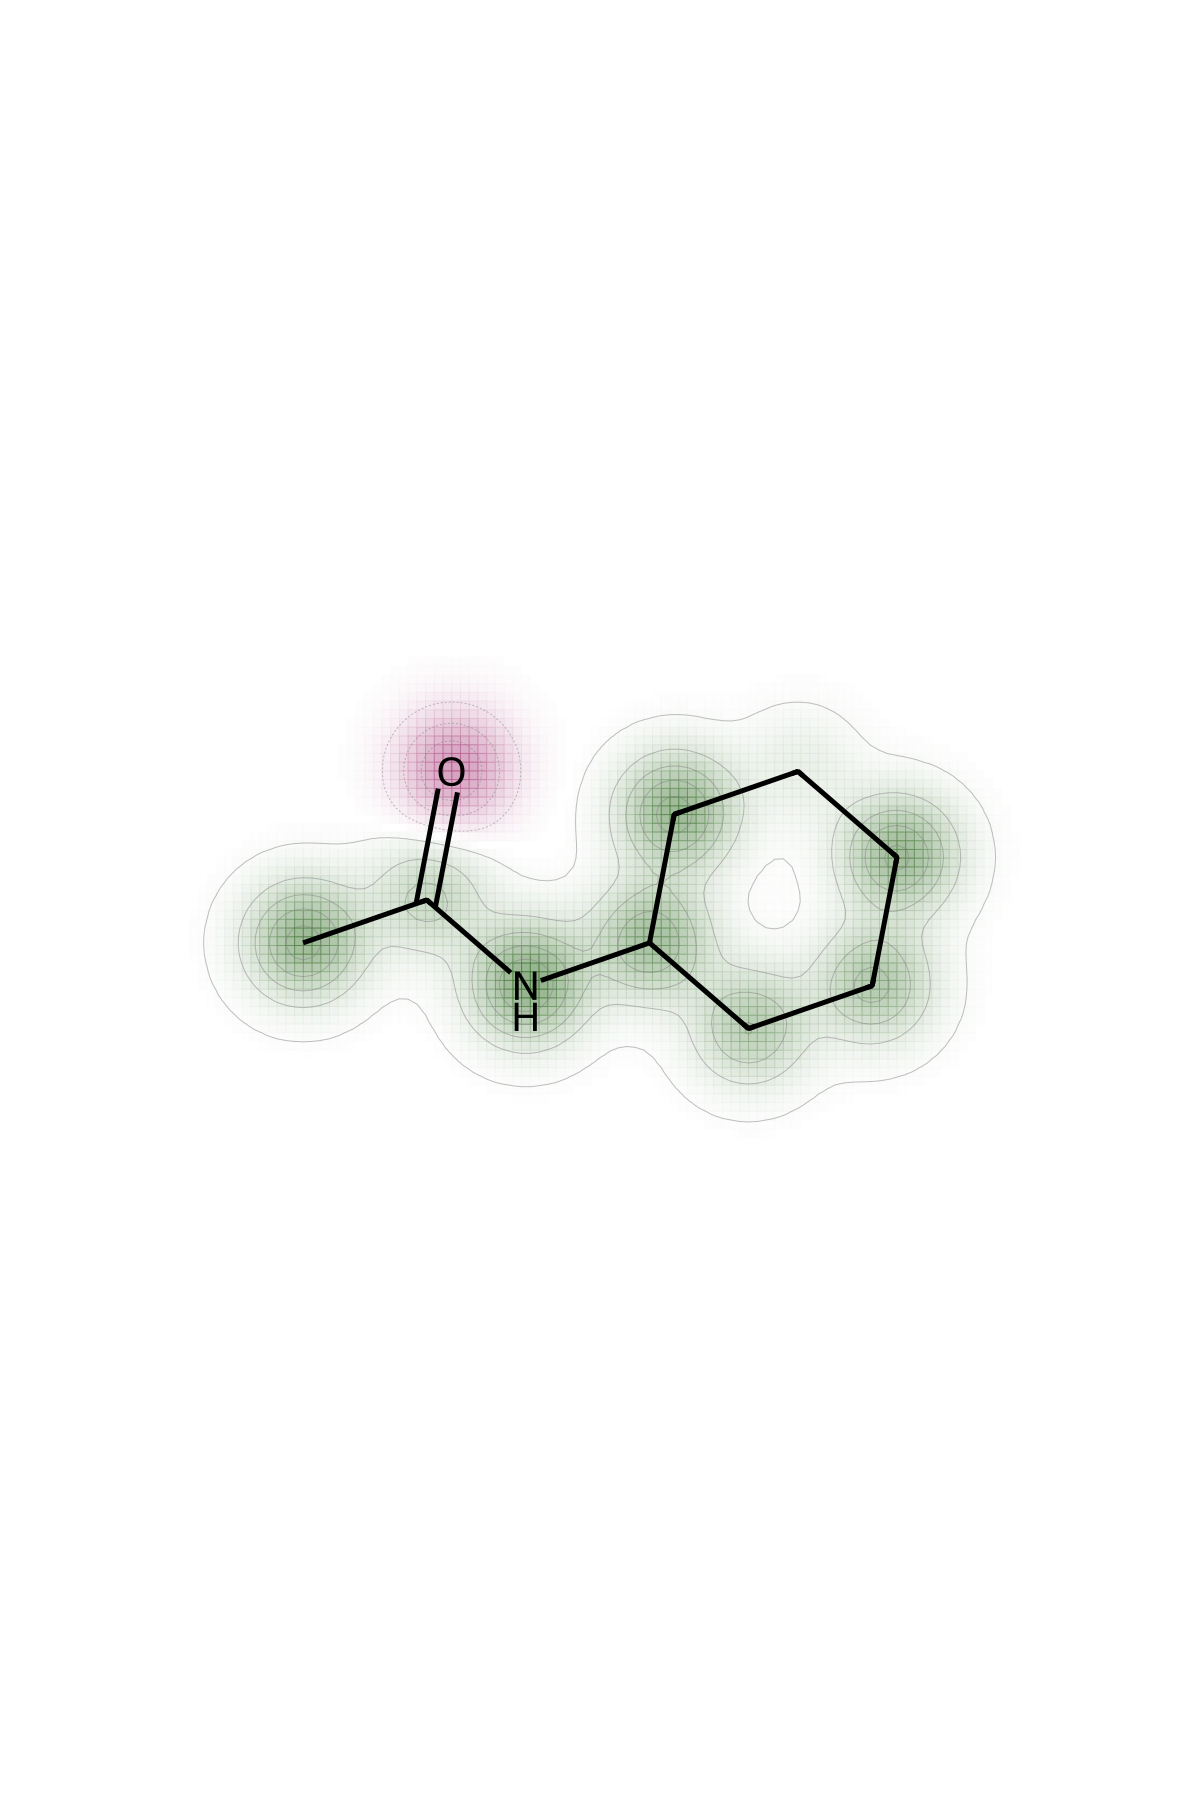

In [ ]:
og = "CC(C1C(CC(C2C1CCCC2)C)NC(C3CC3)=O)C" #umami
a1 = "CC(C1C(CCC2C1CCCC2)NC(C3CC3)=O)C" #umami
a2 = "O=C(C1CC1)NC2CC(CCCC3)C3C(C)C2"   # umami
a3 = "CC(C1C(CC(CC1)C)NC(C2CC2)=O)C"   # umami
a4 = "O=C(C1CC1)NC2CCCCC2"    # umami
a5 = "CC(C1C(CC(C2C1CCCC2)C)NC(C)=O)C" # umami
a6 = "CC(NC1CCCCC1)=O" # undefined

save_high_quality_png(og, "original", padding=0.1)
save_high_quality_png(a1, "analog1", padding=0.1)
save_high_quality_png(a2, "analog2", padding=0.1)
save_high_quality_png(a3, "analog3", padding=0.1)
save_high_quality_png(a4, "analog4", padding=0.1)
save_high_quality_png(a5, "analog5", padding=0.1)
save_high_quality_png(a6, "analog6", padding=0.1)
